### Import Modules

In [10]:
# general
import pandas as pd
import numpy as np
import time

#sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, precision_score, roc_curve, auc, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score
from xgboost.sklearn import XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_validate
import matplotlib.pyplot as plt

In [11]:
master = pd.read_csv('../data/master.csv').drop(['Unnamed: 0'], axis=1)
master['event'] = (master['event'] == 'YES').astype(int)
master.head()

,batter_name,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,...,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score,event
0,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.419183,0.399777,0.145880,2.199052,3.868374,0.241963,0.214890,0.149606,126,0
1,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.437288,0.487069,0.301724,2.295181,5.647414,0.192513,0.347594,0.123077,21,0
2,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.375445,0.411111,0.191111,1.812317,4.786667,0.218750,0.256944,0.297297,193,0
3,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.401862,0.443603,0.213805,1.978339,3.733838,0.295063,0.234214,0.117647,157,0
4,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.401862,0.443603,0.213805,1.978339,3.733838,0.295063,0.234214,0.117647,157,0


In [12]:
master.shape

(139197, 49)

In [13]:
train, test = train_test_split(master, test_size=0.2,random_state=42)

In [14]:
target = 'event'
IDcol = 'batter_name'

In [15]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #print(model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Baseline model


Model Report
Accuracy : 0.9622
AUC Score (Train): 0.711561
81.52485370635986


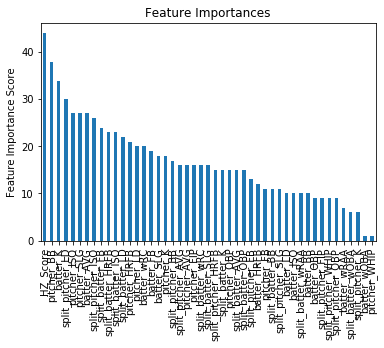

In [17]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
before = time.time()
xgb1 = XGBClassifier(
 tree_method = 'gpu_hist', 
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 20,
 min_child_weight = 1,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb1, train, predictors)

after = time.time()
print(after - before)

## Tuning Parameters

### Max depth, minimum child weight

In [9]:
param_test1 = {
 'max_depth':range(1,6),
 'min_child_weight':range(1,20)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(tree_method = 'gpu_hist',
                                                  learning_rate = 0.1,
                                                  n_estimators = 140,
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  gamma = 0,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 4,
                                                  scale_pos_weight = 1,
                                                  seed = 27),
                        param_grid = param_test1,
                        scoring = 'roc_auc',
                        n_jobs = 4,
                        iid = False,
                        cv = 2)

gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([3.96831584, 4.06566358, 3.43996096, 3.79851556, 3.32693374,
         3.58734941, 3.34419429, 3.5773133 , 3.33475018, 3.59709346,
         3.38266206, 3.61957741, 3.34387743, 3.52857697, 3.38728321,
         3.62024522, 3.45476925, 3.66329503, 3.52631044, 4.0368402 ,
         3.89734459, 4.00388086, 3.96829891, 4.0694499 , 3.99950373,
         4.03071284, 4.07118952, 3.87892139, 3.9405185 , 3.93948925,
         3.95682871, 3.9835211 , 3.92936826, 3.87207282, 3.85102832,
         3.90164018, 3.91607594, 3.90030026, 4.5763526 , 4.3310895 ,
         4.40061116, 4.43687713, 4.41388881, 4.35347676, 4.46154618,
         4.38233852, 4.3794415 , 4.52846503, 4.43430543, 4.59726858,
         4.63835323, 4.62553525, 4.44135475, 4.41683722, 4.38053989,
         4.45958829, 4.49646163, 5.78034604, 5.59628856, 5.53984463,
         5.57300341, 5.60118377, 5.51744807, 5.6638788 , 5.32388949,
         5.67454374, 5.41120291, 5.62865376, 5.49872708, 5.49627411,
         5.511976

In [10]:
best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']

In [11]:
param_test2 = {
 'max_depth':[best_max_depth - 1, best_max_depth, best_max_depth + 1],
 'min_child_weight':[best_min_child_weight - 2 , 
                     best_min_child_weight - 1, 
                     best_min_child_weight,
                     best_min_child_weight + 1,
                     best_min_child_weight + 2]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(tree_method = 'gpu_hist',
                                                  learning_rate = 0.1,
                                                  n_estimators = 140,
                                                  max_depth = best_max_depth,
                                                  min_child_weight = best_min_child_weight,
                                                  gamma = 0,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 4,
                                                  scale_pos_weight = 1,
                                                  seed = 27),
                        param_grid = param_test2,
                        scoring ='roc_auc',
                        n_jobs = 4,
                        iid = False,
                        cv = 2)

gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([2.16293538, 8.2764138 , 4.14605236, 3.86749732, 3.76101482,
         4.1799767 , 4.16350365, 4.06550014, 4.11737776, 4.41860998,
         5.12513673, 4.89822936, 5.33389103, 4.89143753, 4.54750049]),
  'std_fit_time': array([6.23643398e-03, 1.03493333e-01, 3.17964554e-01, 4.83778715e-02,
         4.21415567e-02, 7.65566826e-02, 5.86102009e-02, 2.09456682e-02,
         1.39605999e-02, 6.53461218e-02, 6.30987883e-02, 2.54392624e-04,
         1.81049466e-01, 4.34114933e-02, 2.66815424e-02]),
  'mean_score_time': array([1.92227805, 0.16334558, 0.14813435, 0.14739001, 0.13891292,
         0.13690996, 0.14215147, 0.14364481, 0.13891256, 0.1548686 ,
         0.14963019, 0.15536737, 0.15461659, 0.13814676, 0.13217664]),
  'std_score_time': array([1.34707689e-02, 1.62098408e-02, 1.31130219e-06, 3.73709202e-03,
         7.73286819e-03, 1.02248192e-02, 6.48725033e-03, 7.48205185e-03,
         6.73329830e-03, 7.73167610e-03, 5.48374653e-03, 9.22799110e-03,
         7.4782

In [12]:
best_max_depth = gsearch2.best_params_['max_depth']
best_min_child_weight = gsearch2.best_params_['min_child_weight']

### Model check

In [ ]:
modelfit(gsearch2.best_estimator_, train, predictors)

### Gamma

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(tree_method = 'gpu_hist',
                                                  learning_rate = 0.1,
                                                  n_estimators = 140,
                                                  max_depth = best_max_depth,
                                                  min_child_weight = best_min_child_weight,
                                                  gamma = 0,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 4,
                                                  scale_pos_weight = 1,
                                                  seed = 27),
                        param_grid = param_test3,
                        scoring = 'roc_auc',
                        n_jobs = 4,
                        iid = False,
                        cv = 5)

gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
best_gamma = gsearch3.best_params_['gamma']

### Model check

In [ ]:
xgb2 = XGBClassifier(
 tree_method = 'gpu_hist',
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = best_max_depth,
 min_child_weight = best_min_child_weight,
 gamma = best_gamma,
 subsample = 0.5,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb2, train, predictors)

### Subsample, Colsample

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(tree_method = 'gpu_hist',
                                                  learning_rate = 0.1, 
                                                  n_estimators = 177, 
                                                  max_depth = best_max_depth,
                                                  min_child_weight = best_min_child_weight,
                                                  gamma = best_gamma,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 4,
                                                  scale_pos_weight = 1,
                                                  seed = 27),
                        param_grid = param_test4, 
                        scoring = 'roc_auc',
                        n_jobs = 4,
                        iid = False, 
                        cv = 5)

gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
best_colsample_bytree = gsearch4.best_params_['colsample_bytree']
best_subsample = gsearch4.best_params_['subsample']

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(best_subsample - 5 ,best_subsample, 5)],
 'colsample_bytree':[i/100.0 for i in range(best_colsample_bytree / 2, best_colsample_bytree, 5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(tree_method = 'gpu_hist',
                                                  learning_rate = 0.1, 
                                                  n_estimators = 177, 
                                                  max_depth = best_max_depth,
                                                  min_child_weight = best_min_child_weight,
                                                  gamma = best_gamma,
                                                  subsample = best_subsample,
                                                  colsample_bytree = best_colsample_bytree,
                                                  objective = 'binary:logistic',
                                                  nthread = 4,
                                                  scale_pos_weight = 1,
                                                  seed = 27), 
                        param_grid = param_test5, 
                        scoring = 'roc_auc',
                        n_jobs = 4,
                        iid = False, 
                        cv = 5)

gsearch5.fit(train[predictors],train[target])

In [ ]:
best_colsample_bytree = gsearch5.best_params_['colsample_bytree']
best_subsample = gsearch5.best_params_['subsample']

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(tree_method = 'gpu_hist',
                                                  learning_rate = 0.1,
                                                  n_estimators = 177,
                                                  max_depth = best_max_depth,
                                                  min_child_weight = best_min_child_weight,
                                                  gamma = best_gamma,
                                                  subsample = best_subsample,
                                                  colsample_bytree = best_colsample_bytree,
                                                  objective = 'binary:logistic',
                                                  nthread = 4,
                                                  scale_pos_weight = 1,
                                                  seed = 27),
                        param_grid = param_test6,
                        scoring = 'roc_auc',
                        n_jobs = 4,
                        iid = False,
                        cv = 5)

gsearch6.fit(train[predictors],train[target])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
best_reg_alpha = gsearch6.best_params_['reg_alpha']

In [ ]:
param_test7 = {
 'reg_alpha':[best_reg_alpha / 10, 
              best_reg_alpha,
              best_reg_alpha * 10,
              best_reg_alpha * 100,
              best_reg_alpha * 1000,
              best_reg_alpha * 10000]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(tree_method = 'gpu_hist',
                                                  learning_rate = 0.1,
                                                  n_estimators = 177,
                                                  max_depth = best_max_depth,
                                                  min_child_weight = best_min_child_weight,
                                                  gamma = best_gamma,
                                                  subsample = best_subsample,
                                                  colsample_bytree = best_colsample_bytree,
                                                  objective = 'binary:logistic',
                                                  nthread = 4,
                                                  scale_pos_weight = 1,
                                                  seed = 27),
                        param_grid = param_test7,
                        scoring = 'roc_auc',
                        n_jobs = 4,
                        iid = False,
                        cv = 5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
best_reg_alpha = gsearch7.best_params_['reg_alpha']

In [ ]:
xgb3 = XGBClassifier(
 tree_method = 'gpu_hist',
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = best_max_depth,
 min_child_weight = best_min_child_weight,
 gamma = best_gamma,
 subsample = best_subsample,
 colsample_bytree = best_colsample_bytree,
 reg_alpha = best_reg_alpha,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb3, train, predictors)

In [ ]:
xgb4 = XGBClassifier(
 tree_method = 'gpu_hist',
 learning_rate = 0.01,
 n_estimators = 1000,
 max_depth = best_max_depth,
 min_child_weight = best_min_child_weight,
 gamma = best_gamma,
 subsample = best_subsample,
 colsample_bytree = best_colsample_bytree,
 reg_alpha = best_reg_alpha,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb4, train, predictors)

### Model selection

In [ ]:
chosen_model = xgb4

In [ ]:
chosen_model.save_model("../models/gbm_model.model")